# Northwind database analysis

## Executive Summary 

In [1]:
#imports
import sqlalchemy
from sqlalchemy import create_engine
from sqlalchemy.orm import Session, sessionmaker
from sqlalchemy import inspect

import numpy as np
import pandas as pd
import matplotlib as plt
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
# create the SQL engine
# to use the large version of the databse:
# engine = create_engine('sqlite:///Northwind_large.sqlite', echo=True)

# to use the small version of the databse:
engine = create_engine('sqlite:///Northwind_small.sqlite', echo=True)

Session = sessionmaker(bind=engine)
session = Session()


In [3]:
# have a look at the tables
inspector = inspect(engine)
print(inspector.get_table_names())


2019-04-11 15:05:24,609 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2019-04-11 15:05:24,611 INFO sqlalchemy.engine.base.Engine ()
2019-04-11 15:05:24,613 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2019-04-11 15:05:24,614 INFO sqlalchemy.engine.base.Engine ()
2019-04-11 15:05:24,617 INFO sqlalchemy.engine.base.Engine SELECT name FROM sqlite_master WHERE type='table' ORDER BY name
2019-04-11 15:05:24,618 INFO sqlalchemy.engine.base.Engine ()
['Category', 'Customer', 'CustomerCustomerDemo', 'CustomerDemographic', 'Employee', 'EmployeeTerritory', 'Order', 'OrderDetail', 'Product', 'Region', 'Shipper', 'Supplier', 'Territory']


In [4]:
def get_columns_info(col_name):
    cols_list = inspector.get_columns(col_name)
    
    print("Table Name: {}".format(col_name))
    print("")
    
    for column in cols_list:
        print("Name: {} \t Type: {}".format(column['name'], column['type']))

get_columns_info('Order')




2019-04-11 15:05:24,632 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("Order")
2019-04-11 15:05:24,634 INFO sqlalchemy.engine.base.Engine ()
Table Name: Order

Name: Id 	 Type: INTEGER
Name: CustomerId 	 Type: VARCHAR(8000)
Name: EmployeeId 	 Type: INTEGER
Name: OrderDate 	 Type: VARCHAR(8000)
Name: RequiredDate 	 Type: VARCHAR(8000)
Name: ShippedDate 	 Type: VARCHAR(8000)
Name: ShipVia 	 Type: INTEGER
Name: Freight 	 Type: DECIMAL
Name: ShipName 	 Type: VARCHAR(8000)
Name: ShipAddress 	 Type: VARCHAR(8000)
Name: ShipCity 	 Type: VARCHAR(8000)
Name: ShipRegion 	 Type: VARCHAR(8000)
Name: ShipPostalCode 	 Type: VARCHAR(8000)
Name: ShipCountry 	 Type: VARCHAR(8000)


In [5]:
con = engine.connect()
rs = con.execute('SELECT * FROM Customer LIMIT 5')

print(rs.fetchall())



2019-04-11 15:05:24,648 INFO sqlalchemy.engine.base.Engine SELECT * FROM Customer LIMIT 5
2019-04-11 15:05:24,651 INFO sqlalchemy.engine.base.Engine ()
[('ALFKI', 'Alfreds Futterkiste', 'Maria Anders', 'Sales Representative', 'Obere Str. 57', 'Berlin', 'Western Europe', '12209', 'Germany', '030-0074321', '030-0076545'), ('ANATR', 'Ana Trujillo Emparedados y helados', 'Ana Trujillo', 'Owner', 'Avda. de la Constitución 2222', 'México D.F.', 'Central America', '05021', 'Mexico', '(5) 555-4729', '(5) 555-3745'), ('ANTON', 'Antonio Moreno Taquería', 'Antonio Moreno', 'Owner', 'Mataderos  2312', 'México D.F.', 'Central America', '05023', 'Mexico', '(5) 555-3932', None), ('AROUT', 'Around the Horn', 'Thomas Hardy', 'Sales Representative', '120 Hanover Sq.', 'London', 'British Isles', 'WA1 1DP', 'UK', '(171) 555-7788', '(171) 555-6750'), ('BERGS', 'Berglunds snabbköp', 'Christina Berglund', 'Order Administrator', 'Berguvsvägen  8', 'Luleå', 'Northern Europe', 'S-958 22', 'Sweden', '0921-12 34 

In [6]:
rs = con.execute('SELECT firstname, lastname, title FROM Employee')
df = pd.DataFrame(rs.fetchall())

df.head()



2019-04-11 15:05:24,662 INFO sqlalchemy.engine.base.Engine SELECT firstname, lastname, title FROM Employee
2019-04-11 15:05:24,665 INFO sqlalchemy.engine.base.Engine ()


,0,1,2
0,Nancy,Davolio,Sales Representative
1,Andrew,Fuller,"Vice President, Sales"
2,Janet,Leverling,Sales Representative
3,Margaret,Peacock,Sales Representative
4,Steven,Buchanan,Sales Manager


In [7]:
def make_column_list(table):
    cols = []  #make an empty list
    cols_dict = inspector.get_columns(table)  # make a dict of the column names from the SQL table
#     print(cols_list)
    for column in cols_dict:
        cols.append(column['name'])
#     print(cols)
    return cols


In [8]:
# small sample of order detail for testing
# rs = con.execute('SELECT * FROM OrderDetail LIMIT 25')

# get full orderdetail
rs = con.execute('SELECT * FROM OrderDetail')
order_detail = pd.DataFrame(rs.fetchall())

column_names = make_column_list('OrderDetail')
order_detail.columns = column_names

order_detail.head()

2019-04-11 15:05:24,702 INFO sqlalchemy.engine.base.Engine SELECT * FROM OrderDetail
2019-04-11 15:05:24,704 INFO sqlalchemy.engine.base.Engine ()
2019-04-11 15:05:24,715 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("OrderDetail")
2019-04-11 15:05:24,716 INFO sqlalchemy.engine.base.Engine ()


,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


In [9]:
column_names = make_column_list('Order')
column_names

['Id',
 'CustomerId',
 'EmployeeId',
 'OrderDate',
 'RequiredDate',
 'ShippedDate',
 'ShipVia',
 'Freight',
 'ShipName',
 'ShipAddress',
 'ShipCity',
 'ShipRegion',
 'ShipPostalCode',
 'ShipCountry']

In [10]:
# test of customer table to pandas dataframe
rs = con.execute('SELECT * FROM Customer LIMIT 5')
customers = pd.DataFrame(rs.fetchall())
column_names = make_column_list('Customer')
customers.columns = column_names

customers.head()


2019-04-11 15:05:24,739 INFO sqlalchemy.engine.base.Engine SELECT * FROM Customer LIMIT 5
2019-04-11 15:05:24,741 INFO sqlalchemy.engine.base.Engine ()
2019-04-11 15:05:24,745 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("Customer")
2019-04-11 15:05:24,746 INFO sqlalchemy.engine.base.Engine ()


,Id,CompanyName,ContactName,ContactTitle,Address,City,Region,PostalCode,Country,Phone,Fax
0,ALFKI,Alfreds Futterkiste,Maria Anders,Sales Representative,Obere Str. 57,Berlin,Western Europe,12209,Germany,030-0074321,030-0076545
1,ANATR,Ana Trujillo Emparedados y helados,Ana Trujillo,Owner,Avda. de la Constitución 2222,México D.F.,Central America,05021,Mexico,(5) 555-4729,(5) 555-3745
2,ANTON,Antonio Moreno Taquería,Antonio Moreno,Owner,Mataderos 2312,México D.F.,Central America,05023,Mexico,(5) 555-3932,None
3,AROUT,Around the Horn,Thomas Hardy,Sales Representative,120 Hanover Sq.,London,British Isles,WA1 1DP,UK,(171) 555-7788,(171) 555-6750
4,BERGS,Berglunds snabbköp,Christina Berglund,Order Administrator,Berguvsvägen 8,Luleå,Northern Europe,S-958 22,Sweden,0921-12 34 65,0921-12 34 67


In [11]:
# test orders table
# rs = con.execute('SELECT * FROM [Order]')
# orders = pd.DataFrame(rs.fetchall())
# orders.head()


# get full orders
rs = con.execute('SELECT * FROM [Order]')
orders = pd.DataFrame(rs.fetchall())

column_names = make_column_list('Order')
orders.columns = column_names

orders.head()

2019-04-11 15:05:24,769 INFO sqlalchemy.engine.base.Engine SELECT * FROM [Order]
2019-04-11 15:05:24,772 INFO sqlalchemy.engine.base.Engine ()


,Id,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry
0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France
1,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany
2,10250,HANAR,4,2012-07-08,2012-08-05,2012-07-12,2,65.83,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,South America,05454-876,Brazil
3,10251,VICTE,3,2012-07-08,2012-08-05,2012-07-15,1,41.34,Victuailles en stock,"2, rue du Commerce",Lyon,Western Europe,69004,France
4,10252,SUPRD,4,2012-07-09,2012-08-06,2012-07-11,2,51.30,Suprêmes délices,"Boulevard Tirou, 255",Charleroi,Western Europe,B-6000,Belgium


In [12]:
# get full customer
rs = con.execute('SELECT * FROM Customer')
customer = pd.DataFrame(rs.fetchall())

column_names = make_column_list('Customer')
customer.columns = column_names

customer.head()

2019-04-11 15:05:24,804 INFO sqlalchemy.engine.base.Engine SELECT * FROM Customer
2019-04-11 15:05:24,807 INFO sqlalchemy.engine.base.Engine ()


,Id,CompanyName,ContactName,ContactTitle,Address,City,Region,PostalCode,Country,Phone,Fax
0,ALFKI,Alfreds Futterkiste,Maria Anders,Sales Representative,Obere Str. 57,Berlin,Western Europe,12209,Germany,030-0074321,030-0076545
1,ANATR,Ana Trujillo Emparedados y helados,Ana Trujillo,Owner,Avda. de la Constitución 2222,México D.F.,Central America,05021,Mexico,(5) 555-4729,(5) 555-3745
2,ANTON,Antonio Moreno Taquería,Antonio Moreno,Owner,Mataderos 2312,México D.F.,Central America,05023,Mexico,(5) 555-3932,None
3,AROUT,Around the Horn,Thomas Hardy,Sales Representative,120 Hanover Sq.,London,British Isles,WA1 1DP,UK,(171) 555-7788,(171) 555-6750
4,BERGS,Berglunds snabbköp,Christina Berglund,Order Administrator,Berguvsvägen 8,Luleå,Northern Europe,S-958 22,Sweden,0921-12 34 65,0921-12 34 67


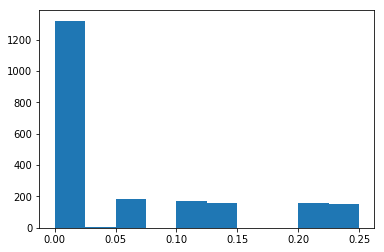

In [13]:
plt.hist(order_detail["Discount"])
plt.show()

In [14]:
# make a new column to calculate the line item total
order_detail['line_total'] = order_detail['Quantity'] * order_detail['UnitPrice'] * (1 - order_detail['Discount'])

In [15]:
order_detail.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,line_total
0,10248/11,10248,11,14.0,12,0.0,168.0
1,10248/42,10248,42,9.8,10,0.0,98.0
2,10248/72,10248,72,34.8,5,0.0,174.0
3,10249/14,10249,14,18.6,9,0.0,167.4
4,10249/51,10249,51,42.4,40,0.0,1696.0


In [16]:
order_detail.describe()

,OrderId,ProductId,UnitPrice,Quantity,Discount,line_total
count,2155.000000,2155.000000,2155.000000,2155.000000,2155.000000,2155.000000
mean,10659.375870,40.793039,26.218520,23.812993,0.056167,587.374960
std,241.378032,22.159019,29.827418,19.022047,0.083450,969.224235
min,10248.000000,1.000000,2.000000,1.000000,0.000000,4.800000
25%,10451.000000,22.000000,12.000000,10.000000,0.000000,147.000000
50%,10657.000000,41.000000,18.400000,20.000000,0.000000,337.750000
75%,10862.500000,60.000000,32.000000,30.000000,0.100000,656.000000
max,11077.000000,77.000000,263.500000,130.000000,0.250000,15810.000000


Idea: Compare orders that contain at least one discounted item to orders that have no discounts.
* Is the average order total higher?
* Is the count of total items ordered higher?
* Is the count of unique products higher?

From prior labs:
q = """SELECT LastName, FirstName, COUNT(*) as TerritoriesAssigned from \
Employee \
JOIN EmployeeTerritory et on Employee.Id = et.employeeId \
GROUP BY Employee.lastname \
ORDER BY TerritoriesAssigned DESC"""

In [43]:
# rs = con.execute('SELECT * FROM [Order] JOIN OrderDetail on Order.OrderID = OrderDetail.OrderID WHERE OrderDetail.Discount > 0')
rs = con.execute('SELECT DISTINCT OrderId FROM OrderDetail WHERE Discount > 0')

orders_with_discount = pd.DataFrame(rs.fetchall())

orders_with_discount.columns = ['Id']

orders_with_discount.count()
orders_with_discount.head()


2019-04-11 16:05:04,786 INFO sqlalchemy.engine.base.Engine SELECT DISTINCT OrderId FROM OrderDetail WHERE Discount > 0
2019-04-11 16:05:04,787 INFO sqlalchemy.engine.base.Engine ()


,Id
0,10250
1,10251
2,10252
3,10254
4,10258


380 out of 830 orders have at least one discounted product on the order.

In [44]:
orders.head()

,Id,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry
0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France
1,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany
2,10250,HANAR,4,2012-07-08,2012-08-05,2012-07-12,2,65.83,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,South America,05454-876,Brazil
3,10251,VICTE,3,2012-07-08,2012-08-05,2012-07-15,1,41.34,Victuailles en stock,"2, rue du Commerce",Lyon,Western Europe,69004,France
4,10252,SUPRD,4,2012-07-09,2012-08-06,2012-07-11,2,51.30,Suprêmes délices,"Boulevard Tirou, 255",Charleroi,Western Europe,B-6000,Belgium


In [55]:
# make a list of orders that have no discounted items
orders_without_discount = orders.merge(orders_with_discount.drop_duplicates(), on=['Id'], how='left', indicator=True)

orders_without_discount = orders_without_discount[orders_without_discount._merge != 'both']

# orders_without_discount.head()

orders_without_discount.count()

# sources
# https://stackoverflow.com/questions/28901683/pandas-get-rows-which-are-not-in-other-dataframe
# https://chrisalbon.com/python/data_wrangling/pandas_dropping_column_and_rows/

Id                450
CustomerId        450
EmployeeId        450
OrderDate         450
RequiredDate      450
ShippedDate       440
ShipVia           450
Freight           450
ShipName          450
ShipAddress       450
ShipCity          450
ShipRegion        450
ShipPostalCode    446
ShipCountry       450
_merge            450
dtype: int64

(array([2.011e+03, 1.070e+02, 1.800e+01, 8.000e+00, 4.000e+00, 2.000e+00,
        3.000e+00, 0.000e+00, 0.000e+00, 2.000e+00]),
 array([4.800000e+00, 1.585320e+03, 3.165840e+03, 4.746360e+03,
        6.326880e+03, 7.907400e+03, 9.487920e+03, 1.106844e+04,
        1.264896e+04, 1.422948e+04, 1.581000e+04]),
 <a list of 10 Patch objects>)

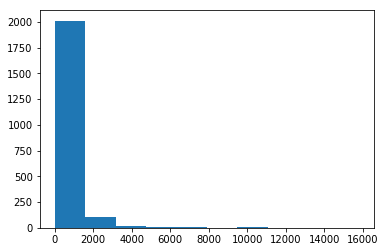

In [17]:
plt.hist(order_detail['line_total'])

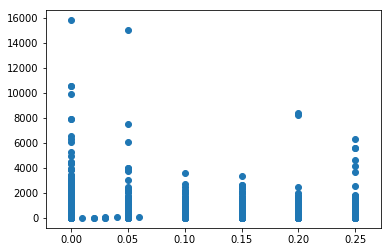

In [18]:
plt.scatter(order_detail['Discount'], order_detail['line_total'])

Idea - Make a pandas dataframe of all orders where there is any item with a discount. 
Within those orders, what are the summary statistics for:
* The number of different SKU's in the order 
* Quantity of each SKU ordered. How does this compare to orders where the samei SKU has been ordered but there was no discount.
* 

And then compare those statistics to orders where there was no item with a discount.










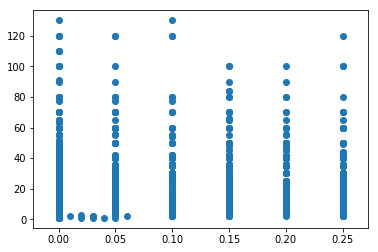

In [19]:
plt.scatter(order_detail['Discount'], order_detail['Quantity'])